## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install albumentations

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-cc7ikavp
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-cc7ikavp
     |████████████████████████████████| 47.6 MB 3.0 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=103647 sha256=4a0b7f75c564dc674df74e493dc77a002372565f10a45dd4d0a6392e6d845695
  Stored in directory: /tmp/pip-ephem-wheel-cache-39lx68qm/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
from albumentations.pytorch import ToTensorV2

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR='/content/drive/My Drive/S9'
%cd $BASE_DIR

Mounted at /content/drive
/content/drive/My Drive/S9


In [4]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_cifar10_custom_resnet import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.customresnet import CustomResNet
from models.main import train_test_loader,imshow, get_model,find_lr_value, train_model
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy,plot_accuracy,plot_max_lr_vs_test_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcamkz_util import GRADCAM, PLOT,PLOTGRADCAM,process_for_grad_cam
from utils.cyclic_lr_util import triangle_lr_plot,custom_one_cycle_lr, max_lr_finder_schedule

 ## Loading and normalizing CIFAR10

In [ ]:
BATCH_SIZE=512
trainloader, testloader, classes,transform_train,transform_test = train_test_loader(BATCH_SIZE,get_train_transform, get_test_transform,get_train_loader, get_test_loader, get_classes)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:694: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car horse plane  deer


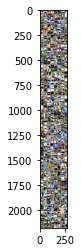

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define custom ResNet Model

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = get_model(CustomResNet)
print(model)
summary(model, input_size=(3, 32, 32))

CustomResNet(
  (conv): ConvBNBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.0, inplace=False)
  )
  (layer1): ResBlock(
    (transition_block): TransitionBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block1): ConvBNBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block2): ConvBNBlock(
      (conv): Conv2d(128, 1

/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## LR Range Test

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

model = get_model(CustomResNet)
PATH_BASE_MODEL = 'base_weights_lr_range_test.pth'
torch.save(model.state_dict(), PATH_BASE_MODEL)
EPOCHS_TO_TRY = 5
max_lr_list = [0.001, 0.004, 0.008, 0.01,0.04,0.08,0.1,0.4,0.8,1,2,4]
test_accuracy_list = []
find_lr_value(model,EPOCHS_TO_TRY,max_lr_list,test_accuracy_list,PATH_BASE_MODEL,max_lr_finder_schedule,BATCH_SIZE,train,test,trainloader,testloader)

MAX LR: 0.001  EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=3.429975986480713 Batch_id=97 Accuracy=6.33: 100%|██████████| 98/98 [00:56<00:00,  1.74it/s]



Test set: Average loss: 3.4920, Accuracy: 581/10000 (5.81%)

MAX LR: 0.001  EPOCH: 2


Loss=3.27433443069458 Batch_id=97 Accuracy=6.44: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 3.4719, Accuracy: 592/10000 (5.92%)

MAX LR: 0.001  EPOCH: 3


Loss=3.292482614517212 Batch_id=97 Accuracy=6.30: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 3.4206, Accuracy: 584/10000 (5.84%)

MAX LR: 0.001  EPOCH: 4


Loss=3.364572525024414 Batch_id=97 Accuracy=6.46: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 3.3677, Accuracy: 592/10000 (5.92%)

MAX LR: 0.001  EPOCH: 5


Loss=3.2371132373809814 Batch_id=97 Accuracy=6.55: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 3.3157, Accuracy: 588/10000 (5.88%)

 For Max LR:  0.001  Test Accuracy:  5.88
MAX LR: 0.004  EPOCH: 1


Loss=3.28503680229187 Batch_id=97 Accuracy=6.33: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 3.3055, Accuracy: 588/10000 (5.88%)

MAX LR: 0.004  EPOCH: 2


Loss=3.0346391201019287 Batch_id=97 Accuracy=6.94: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.9893, Accuracy: 655/10000 (6.55%)

MAX LR: 0.004  EPOCH: 3


Loss=2.755858898162842 Batch_id=97 Accuracy=7.84: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 2.7140, Accuracy: 770/10000 (7.70%)

MAX LR: 0.004  EPOCH: 4


Loss=2.5523312091827393 Batch_id=97 Accuracy=8.96: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 2.5138, Accuracy: 946/10000 (9.46%)

MAX LR: 0.004  EPOCH: 5


Loss=2.3929784297943115 Batch_id=97 Accuracy=11.04: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 2.3917, Accuracy: 1193/10000 (11.93%)

 For Max LR:  0.004  Test Accuracy:  11.93
MAX LR: 0.008  EPOCH: 1


Loss=2.8255419731140137 Batch_id=97 Accuracy=6.61: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.8789, Accuracy: 683/10000 (6.83%)

MAX LR: 0.008  EPOCH: 2


Loss=2.5104756355285645 Batch_id=97 Accuracy=9.10: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.4495, Accuracy: 1063/10000 (10.63%)

MAX LR: 0.008  EPOCH: 3


Loss=2.339444637298584 Batch_id=97 Accuracy=13.13: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.2950, Accuracy: 1509/10000 (15.09%)

MAX LR: 0.008  EPOCH: 4


Loss=2.216386318206787 Batch_id=97 Accuracy=16.31: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.2280, Accuracy: 1799/10000 (17.99%)

MAX LR: 0.008  EPOCH: 5


Loss=2.1524996757507324 Batch_id=97 Accuracy=18.51: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.1739, Accuracy: 2086/10000 (20.86%)

 For Max LR:  0.008  Test Accuracy:  20.86
MAX LR: 0.01  EPOCH: 1


Loss=2.7228870391845703 Batch_id=97 Accuracy=7.11: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.6831, Accuracy: 789/10000 (7.89%)

MAX LR: 0.01  EPOCH: 2


Loss=2.35077166557312 Batch_id=97 Accuracy=10.67: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.3339, Accuracy: 1372/10000 (13.72%)

MAX LR: 0.01  EPOCH: 3


Loss=2.2742574214935303 Batch_id=97 Accuracy=15.57: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.2352, Accuracy: 1749/10000 (17.49%)

MAX LR: 0.01  EPOCH: 4


Loss=2.1962966918945312 Batch_id=97 Accuracy=18.36: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.1676, Accuracy: 2097/10000 (20.97%)

MAX LR: 0.01  EPOCH: 5


Loss=2.167829990386963 Batch_id=97 Accuracy=20.83: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.1064, Accuracy: 2352/10000 (23.52%)

 For Max LR:  0.01  Test Accuracy:  23.52
MAX LR: 0.04  EPOCH: 1


Loss=2.132542371749878 Batch_id=97 Accuracy=15.85: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.0961, Accuracy: 2416/10000 (24.16%)

MAX LR: 0.04  EPOCH: 2


Loss=1.9783525466918945 Batch_id=97 Accuracy=25.68: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 1.8968, Accuracy: 3180/10000 (31.80%)

MAX LR: 0.04  EPOCH: 3


Loss=1.7593661546707153 Batch_id=97 Accuracy=32.07: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.7339, Accuracy: 3733/10000 (37.33%)

MAX LR: 0.04  EPOCH: 4


Loss=1.7002519369125366 Batch_id=97 Accuracy=36.74: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.6018, Accuracy: 4246/10000 (42.46%)

MAX LR: 0.04  EPOCH: 5


Loss=1.5649046897888184 Batch_id=97 Accuracy=40.84: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.4996, Accuracy: 4571/10000 (45.71%)

 For Max LR:  0.04  Test Accuracy:  45.71
MAX LR: 0.08  EPOCH: 1


Loss=1.8681501150131226 Batch_id=97 Accuracy=22.12: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 1.8463, Accuracy: 3367/10000 (33.67%)

MAX LR: 0.08  EPOCH: 2


Loss=1.714565634727478 Batch_id=97 Accuracy=35.71: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.5736, Accuracy: 4312/10000 (43.12%)

MAX LR: 0.08  EPOCH: 3


Loss=1.5138803720474243 Batch_id=97 Accuracy=43.60: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 1.4208, Accuracy: 4766/10000 (47.66%)

MAX LR: 0.08  EPOCH: 4


Loss=1.4915599822998047 Batch_id=97 Accuracy=48.88: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.2826, Accuracy: 5374/10000 (53.74%)

MAX LR: 0.08  EPOCH: 5


Loss=1.3091646432876587 Batch_id=97 Accuracy=53.47: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.2022, Accuracy: 5607/10000 (56.07%)

 For Max LR:  0.08  Test Accuracy:  56.07
MAX LR: 0.1  EPOCH: 1


Loss=1.831990361213684 Batch_id=97 Accuracy=24.22: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.7493, Accuracy: 3705/10000 (37.05%)

MAX LR: 0.1  EPOCH: 2


Loss=1.6070165634155273 Batch_id=97 Accuracy=39.11: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 1.4680, Accuracy: 4671/10000 (46.71%)

MAX LR: 0.1  EPOCH: 3


Loss=1.4890614748001099 Batch_id=97 Accuracy=46.89: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 1.3191, Accuracy: 5223/10000 (52.23%)

MAX LR: 0.1  EPOCH: 4


Loss=1.1592503786087036 Batch_id=97 Accuracy=52.94: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.1743, Accuracy: 5754/10000 (57.54%)

MAX LR: 0.1  EPOCH: 5


Loss=1.1814115047454834 Batch_id=97 Accuracy=57.43: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.0882, Accuracy: 6094/10000 (60.94%)

 For Max LR:  0.1  Test Accuracy:  60.94
MAX LR: 0.4  EPOCH: 1


Loss=1.3947287797927856 Batch_id=97 Accuracy=38.84: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.5815, Accuracy: 4733/10000 (47.33%)

MAX LR: 0.4  EPOCH: 2


Loss=1.1315840482711792 Batch_id=97 Accuracy=56.72: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.2201, Accuracy: 5893/10000 (58.93%)

MAX LR: 0.4  EPOCH: 3


Loss=1.0991721153259277 Batch_id=97 Accuracy=64.73: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.6224, Accuracy: 5798/10000 (57.98%)

MAX LR: 0.4  EPOCH: 4


Loss=0.9303345680236816 Batch_id=97 Accuracy=69.14: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 0.8616, Accuracy: 7056/10000 (70.56%)

MAX LR: 0.4  EPOCH: 5


Loss=0.7276870012283325 Batch_id=97 Accuracy=74.34: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 0.7291, Accuracy: 7601/10000 (76.01%)

 For Max LR:  0.4  Test Accuracy:  76.01
MAX LR: 0.8  EPOCH: 1


Loss=1.6426851749420166 Batch_id=97 Accuracy=29.50: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.5646, Accuracy: 4538/10000 (45.38%)

MAX LR: 0.8  EPOCH: 2


Loss=1.627446174621582 Batch_id=97 Accuracy=44.22: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.8953, Accuracy: 4560/10000 (45.60%)

MAX LR: 0.8  EPOCH: 3


Loss=1.2738186120986938 Batch_id=97 Accuracy=53.76: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.8759, Accuracy: 5291/10000 (52.91%)

MAX LR: 0.8  EPOCH: 4


Loss=1.2326072454452515 Batch_id=97 Accuracy=56.63: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.9858, Accuracy: 6173/10000 (61.73%)

MAX LR: 0.8  EPOCH: 5


Loss=2.027865409851074 Batch_id=97 Accuracy=63.24: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 2.9024, Accuracy: 6274/10000 (62.74%)

 For Max LR:  0.8  Test Accuracy:  62.74
MAX LR: 1  EPOCH: 1


Loss=2.318225622177124 Batch_id=97 Accuracy=19.02: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 2.7781, Accuracy: 2189/10000 (21.89%)

MAX LR: 1  EPOCH: 2


Loss=3.5932998657226562 Batch_id=97 Accuracy=30.80: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 4.2647, Accuracy: 3061/10000 (30.61%)

MAX LR: 1  EPOCH: 3


Loss=1.5564615726470947 Batch_id=97 Accuracy=35.22: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.6618, Accuracy: 4423/10000 (44.23%)

MAX LR: 1  EPOCH: 4


Loss=1.5130789279937744 Batch_id=97 Accuracy=48.53: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.5554, Accuracy: 4820/10000 (48.20%)

MAX LR: 1  EPOCH: 5


Loss=1.1349177360534668 Batch_id=97 Accuracy=57.20: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.3962, Accuracy: 5719/10000 (57.19%)

 For Max LR:  1  Test Accuracy:  57.19
MAX LR: 2  EPOCH: 1


Loss=2.297361373901367 Batch_id=97 Accuracy=11.50: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 2.3237, Accuracy: 1663/10000 (16.63%)

MAX LR: 2  EPOCH: 2


Loss=2.1526358127593994 Batch_id=97 Accuracy=18.28: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 2.0357, Accuracy: 2558/10000 (25.58%)

MAX LR: 2  EPOCH: 3


Loss=1.7145582437515259 Batch_id=97 Accuracy=29.21: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 1.9114, Accuracy: 3171/10000 (31.71%)

MAX LR: 2  EPOCH: 4


Loss=1.4994239807128906 Batch_id=97 Accuracy=38.96: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 1.5740, Accuracy: 4244/10000 (42.44%)

MAX LR: 2  EPOCH: 5


Loss=1.2787792682647705 Batch_id=97 Accuracy=48.78: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.3109, Accuracy: 5468/10000 (54.68%)

 For Max LR:  2  Test Accuracy:  54.68
MAX LR: 4  EPOCH: 1


Loss=2.3353116512298584 Batch_id=97 Accuracy=10.41: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 2.8186, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 2


Loss=2.3158013820648193 Batch_id=97 Accuracy=10.02: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 2.3117, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 3


Loss=2.3007781505584717 Batch_id=97 Accuracy=9.98: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 2.3058, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 4


Loss=2.317802906036377 Batch_id=97 Accuracy=9.99: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 2.3143, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 5


Loss=2.3106324672698975 Batch_id=97 Accuracy=9.78: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 2.3057, Accuracy: 1000/10000 (10.00%)

 For Max LR:  4  Test Accuracy:  10.0


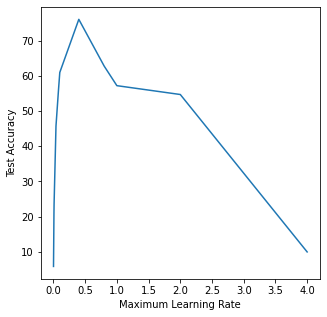

In [ ]:
plot_max_lr_vs_test_accuracy(max_lr_list,test_accuracy_list)

## Model Training

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")      
model = get_model(CustomResNet)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
EPOCHS = 24

one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=0.08, max_lr=0.8, final_lr=0.008, epoch_stage1=5, epoch_stage2=18, total_epochs=24)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr])
PATH = '/content/drive/My Drive/cifar10_resnet18_one_cyclic_lr_final_2.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
train_model(best_test_accuracy,EPOCHS, model,trainloader,testloader,optimizer,train,test,train_losses,test_losses,scheduler,train_acc,test_acc,PATH)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.2821202278137207 Batch_id=97 Accuracy=40.43: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 1.3086, Accuracy: 5399/10000 (53.99%)

Test Accuracy: 53.99 has increased. Saving the model
EPOCH: 2


Loss=1.3674408197402954 Batch_id=97 Accuracy=57.37: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 1.2467, Accuracy: 6043/10000 (60.43%)

Test Accuracy: 60.43 has increased. Saving the model
EPOCH: 3


Loss=1.0467630624771118 Batch_id=97 Accuracy=64.95: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 1.0122, Accuracy: 6807/10000 (68.07%)

Test Accuracy: 68.07 has increased. Saving the model
EPOCH: 4


Loss=0.8910414576530457 Batch_id=97 Accuracy=67.84: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 0.8603, Accuracy: 7287/10000 (72.87%)

Test Accuracy: 72.87 has increased. Saving the model
EPOCH: 5


Loss=0.9103121757507324 Batch_id=97 Accuracy=74.65: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 1.1098, Accuracy: 6995/10000 (69.95%)

EPOCH: 6


Loss=0.564529538154602 Batch_id=97 Accuracy=77.42: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 0.7642, Accuracy: 7706/10000 (77.06%)

Test Accuracy: 77.06 has increased. Saving the model
EPOCH: 7


Loss=0.5887299180030823 Batch_id=97 Accuracy=81.33: 100%|██████████| 98/98 [00:55<00:00,  1.77it/s]



Test set: Average loss: 0.6437, Accuracy: 8001/10000 (80.01%)

Test Accuracy: 80.01 has increased. Saving the model
EPOCH: 8


Loss=0.33342957496643066 Batch_id=97 Accuracy=83.60: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 0.6496, Accuracy: 7972/10000 (79.72%)

EPOCH: 9


Loss=0.4106210470199585 Batch_id=97 Accuracy=85.87: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]



Test set: Average loss: 0.4620, Accuracy: 8514/10000 (85.14%)

Test Accuracy: 85.14 has increased. Saving the model
EPOCH: 10


Loss=0.3624134957790375 Batch_id=97 Accuracy=87.35: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.4397, Accuracy: 8571/10000 (85.71%)

Test Accuracy: 85.71 has increased. Saving the model
EPOCH: 11


Loss=0.323405385017395 Batch_id=97 Accuracy=88.90: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.4165, Accuracy: 8650/10000 (86.50%)

Test Accuracy: 86.5 has increased. Saving the model
EPOCH: 12


Loss=0.34409767389297485 Batch_id=97 Accuracy=90.30: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.4247, Accuracy: 8697/10000 (86.97%)

Test Accuracy: 86.97 has increased. Saving the model
EPOCH: 13


Loss=0.2811940610408783 Batch_id=97 Accuracy=91.14: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.4155, Accuracy: 8788/10000 (87.88%)

Test Accuracy: 87.88 has increased. Saving the model
EPOCH: 14


Loss=0.22680529952049255 Batch_id=97 Accuracy=92.17: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 0.3654, Accuracy: 8876/10000 (88.76%)

Test Accuracy: 88.76 has increased. Saving the model
EPOCH: 15


Loss=0.18747879564762115 Batch_id=97 Accuracy=93.15: 100%|██████████| 98/98 [00:56<00:00,  1.75it/s]



Test set: Average loss: 0.3601, Accuracy: 8879/10000 (88.79%)

Test Accuracy: 88.79 has increased. Saving the model
EPOCH: 16


Loss=0.1353045552968979 Batch_id=97 Accuracy=93.98: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3648, Accuracy: 8909/10000 (89.09%)

Test Accuracy: 89.09 has increased. Saving the model
EPOCH: 17


Loss=0.15059086680412292 Batch_id=97 Accuracy=94.42: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3353, Accuracy: 8994/10000 (89.94%)

Test Accuracy: 89.94 has increased. Saving the model
EPOCH: 18


Loss=0.11599750816822052 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3181, Accuracy: 9005/10000 (90.05%)

Test Accuracy: 90.05 has increased. Saving the model
EPOCH: 19


Loss=0.13956400752067566 Batch_id=97 Accuracy=95.56: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3095, Accuracy: 9054/10000 (90.54%)

Test Accuracy: 90.54 has increased. Saving the model
EPOCH: 20


Loss=0.15439008176326752 Batch_id=97 Accuracy=95.78: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3193, Accuracy: 9035/10000 (90.35%)

EPOCH: 21


Loss=0.13163802027702332 Batch_id=97 Accuracy=95.74: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3093, Accuracy: 9056/10000 (90.56%)

Test Accuracy: 90.56 has increased. Saving the model
EPOCH: 22


Loss=0.15073522925376892 Batch_id=97 Accuracy=95.96: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3101, Accuracy: 9052/10000 (90.52%)

EPOCH: 23


Loss=0.06864310055971146 Batch_id=97 Accuracy=96.21: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3107, Accuracy: 9066/10000 (90.66%)

Test Accuracy: 90.66 has increased. Saving the model
EPOCH: 24


Loss=0.14406953752040863 Batch_id=97 Accuracy=96.19: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 0.3042, Accuracy: 9088/10000 (90.88%)

Test Accuracy: 90.88 has increased. Saving the model


## Testing the model using testing data

In [ ]:
model.load_state_dict(torch.load(PATH))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


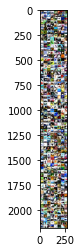

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [ ]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 75 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %


## Performance metrics

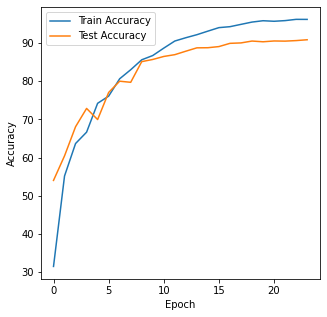

In [ ]:
plot_accuracy(train_acc, test_acc)

## Misclassified Images

/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the va

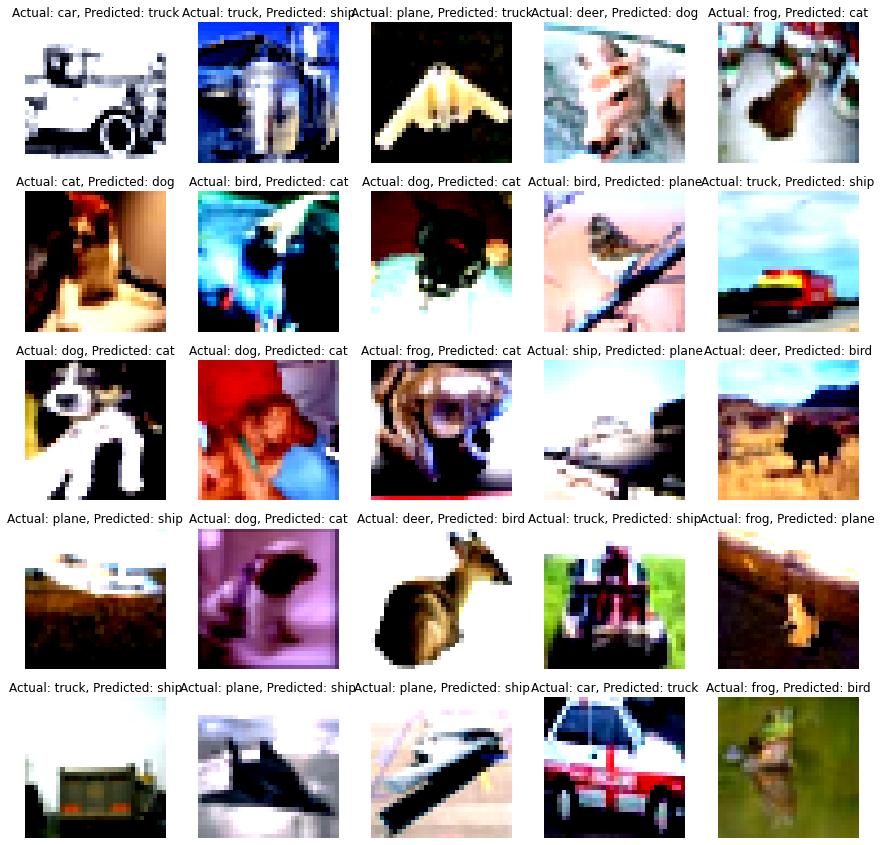

In [ ]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)


In [ ]:
incorrect_images=process_for_grad_cam(incorrect_images_list,predicted_label_list,correct_label_list,transform_test)

## GRADCAM for Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/content/drive/My Drive/CRN/customresnet.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


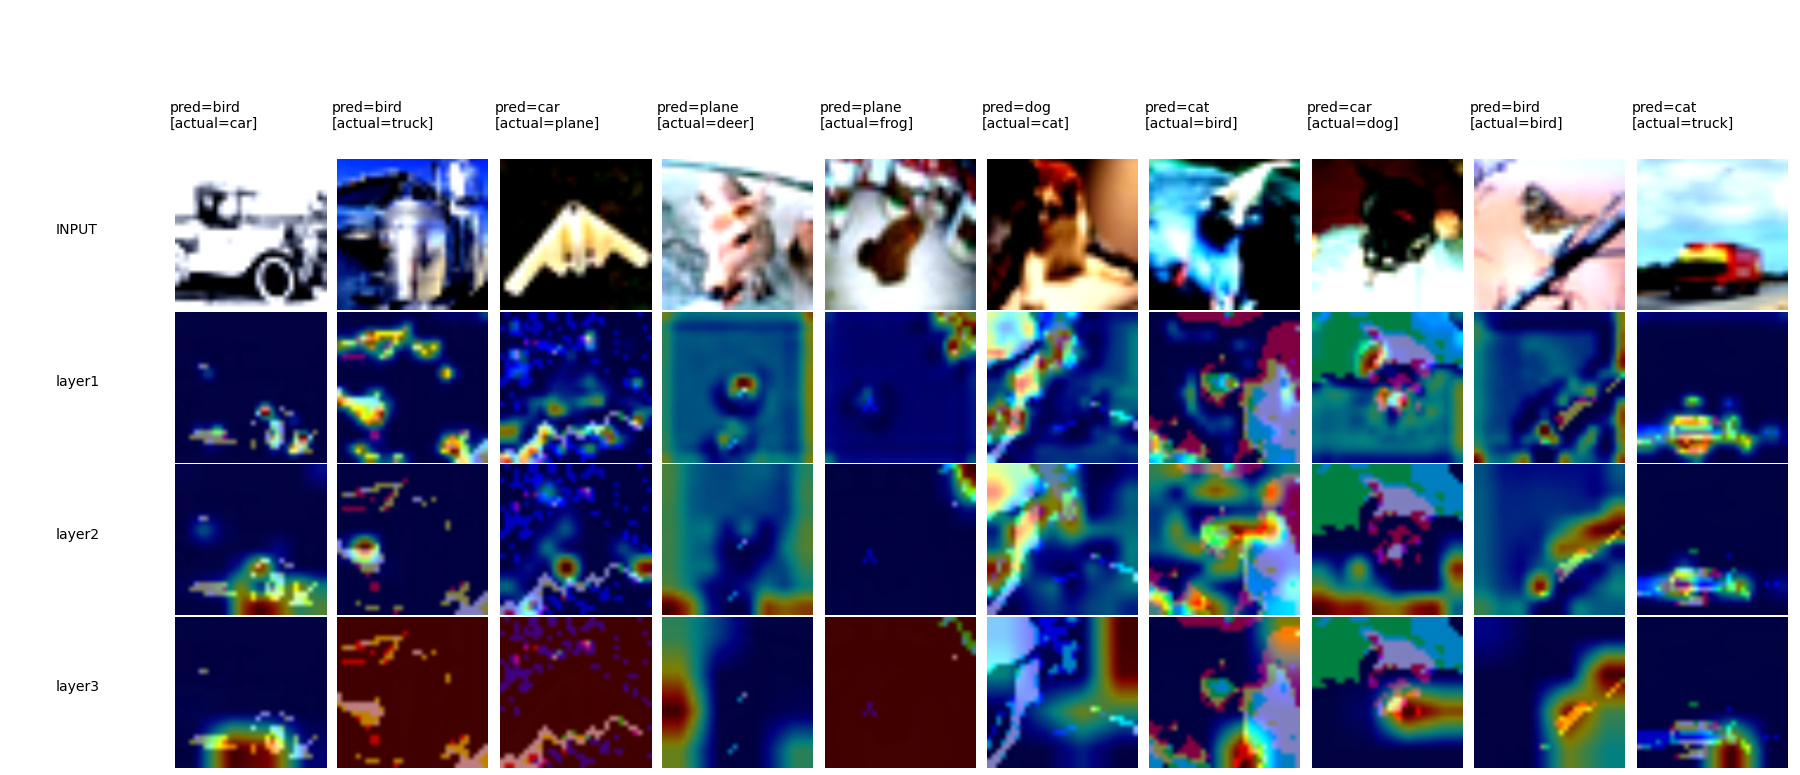

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

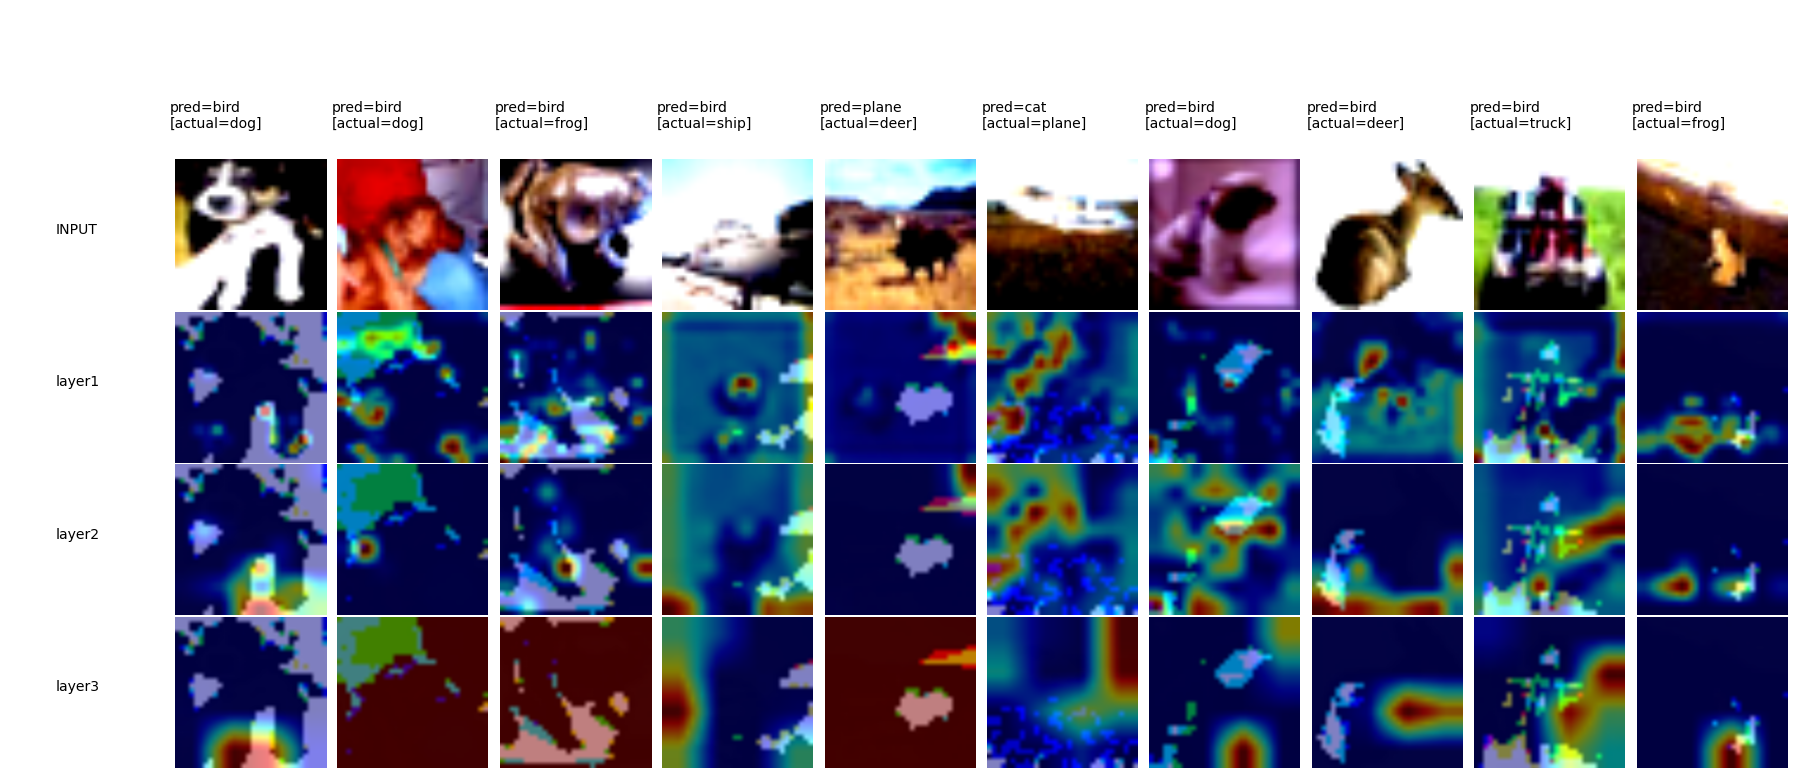

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


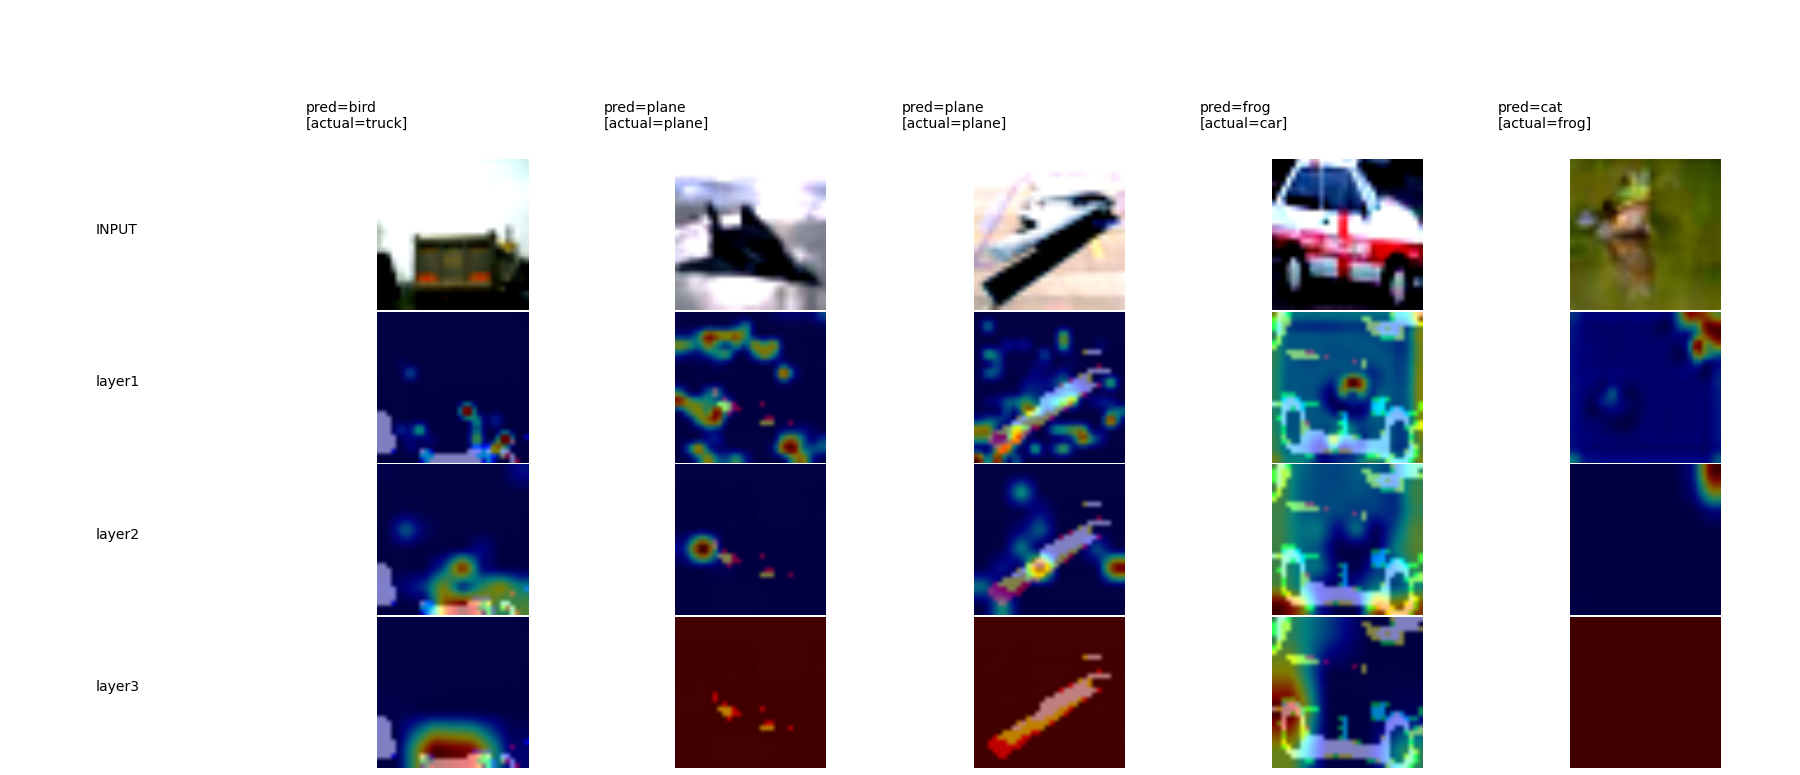

In [ ]:
target_layers = ["layer1", "layer2", "layer3"]
gradcam_output, probs, predicted_classes = GRADCAM(incorrect_images, correct_label_list[0:25], model, target_layers)
print(len(predicted_classes))
PLOTGRADCAM(gradcam_output, incorrect_images_list[0:25],incorrect_images ,correct_label_list[0:25], target_layers, classes, (3, 32, 32), predicted_classes)


In [ ]:
##############################################################################################################################################################